## Lab Assignment Six: Convolutional Network Architectures

### Business Understanding
Brain tumors, either benign or malignant, are a serious health issue that can have severe consequences if not detected and treated early. But due to its location and the complexity of the brain, detecting brain tumors can be challenging. We often don't know if we have a brain tumor until we start experiencing symptoms due to the lack of pain receptors in the brain. By the time symptoms appear, the tumor may have already grown to a size that can cause serious damage. [What Does a Brain Tumor Feel Like?](https://www.houstonmethodist.org/blog/articles/2024/nov/what-does-a-brain-tumor-feel-like/#:~:text=It%27s%20hard%20to%20believe%2C%20but,brain%20irritated%20by%20the%20tumor.) This is why early detection is crucial in treating brain tumors.

Yet we often rely on medical imaging techniques such as Magnetic Resonance Imaging (MRI) to detect the presence of tumors in the brain. However, the process of analyzing MRI images to identify tumors can be time-consuming and require expert knowledge. In this article " [How to Become an MRI Technologist](https://www.mtmi.net/blog/how-to-become-mri-technologist#:~:text=Becoming%20an%20MRI%20technologist%20takes,are%20familiar%20with%20MRI%20technology.)", MRI technologists are required to have background in radiologic technology or a related field on top of their medical degree. On top of that, MRI results can be subjective and can vary between radiologists. This can lead to misdiagnosis and delayed treatment for patients. The accuracy of the diagnosis can often depend on the experience and expertise of the radiologist interpreting the images. As a result , it is hard offer MRI as a periodic check-up due to its expensive and time-consuming nature.

This is where machine learning can help. By training a machine learning model on a dataset of labeled brain MRI images, we can develop a model that can automatically detect the presence of a tumor in brain MRI images. This can help radiologists and medical professionals quickly and accurately identify tumors in brain MRI images, which can lead to faster diagnosis and treatment for patients.

To achieve this goal, we used a dataset titled "[Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)" that includes 3264 brain MRI images of four different tumor types: meningioma, glioma, pituitary, and no tumor. The dataset is organized into two folders: Training and Testing, with each folder containing subfolders for each tumor type. The images are in PNG format and have varying dimensions. For the purpose of this project, we decided to combine Training and Testing dataset into one dataset to ensure that the model is trained on as much data as possible to improve its performance. This dataset will be used to train a convolutional neural network (CNN) to classify brain MRI images into either tumors or no tumors.

### Preparation




In [9]:
# Load the data
import os
def get_image_paths(base_path):

    testing_dir = os.path.join(base_path, "Testing")
    training_dir = os.path.join(base_path, "Training")

    # Collect all relative image paths from Testing and Training
    testing_paths = []
    training_paths = []

    for folder_name in os.listdir(testing_dir):
        folder_path = os.path.join(testing_dir, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            testing_paths.extend(
                [os.path.relpath(os.path.join(folder_path, file), base_path) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            )

    for folder_name in os.listdir(training_dir):
        folder_path = os.path.join(training_dir, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            training_paths.extend(
                [os.path.relpath(os.path.join(folder_path, file), base_path) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            )

    return testing_paths, training_paths

base_path = "dataset"  # The relative path to your dataset folder
testing_paths, training_paths = get_image_paths(base_path)

print("Number of Testing images:", len(testing_paths))
print("Number of Training images:", len(training_paths))


Number of Testing images: 394
Number of Training images: 2870


In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt

def count_images_by_group(image_paths):
    group_counts = defaultdict(int)
    for path in image_paths:
        # Extract group name from the path
        group_name = os.path.normpath(path).split(os.sep)[1]  # Get second component
        group_counts[group_name] += 1
    return group_counts

# Plot results
def plot_image_counts(counts, title):
    groups = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(groups, values)
    plt.xlabel('Tumor Type', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# Combine testing and training datasets
def group_images(testing_paths, training_paths, base_path):
    # Combine testing and training paths
    all_paths = testing_paths + training_paths

    # Dictionary to hold lists of image paths by group
    group_images = defaultdict(list)

    # Group the paths by their corresponding group
    for path in all_paths:
        # Extract group name from the path (second component)
        group_name = os.path.normpath(path).split(os.sep)[1]
        group_images[group_name].append(path)  # Add the path to the group

    return group_images

# Example usage
base_path = "dataset"  # The relative path to your dataset folder
testing_paths, training_paths = get_image_paths(base_path)  # Assuming get_image_paths() is already defined

# Group images by tumor type
grouped_images = group_images(testing_paths, training_paths, base_path)

In [11]:
#
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print(tf.__version__)

def load_images(image_paths, image_size=(256, 256)):
    images = []
    for path in image_paths:
        # Load image
        image = load_img(path, target_size=image_size)
        # Convert to numpy array
        image = img_to_array(image)
        # Normalize pixel values to between 0 and 1
        image /= 255.0
        images.append(image)
    return np.asarray(images)

# Load images for each group
grouped_images_data = {}
for group, paths in grouped_images.items():
    images = load_images([os.path.join(base_path, path) for path in paths])
    grouped_images_data[group] = images
    print(f"Loaded {len(images)} images for {group}")

2.17.0
Loaded 926 images for glioma_tumor
Loaded 937 images for meningioma_tumor
Loaded 500 images for no_tumor
Loaded 901 images for pituitary_tumor


2.17.0


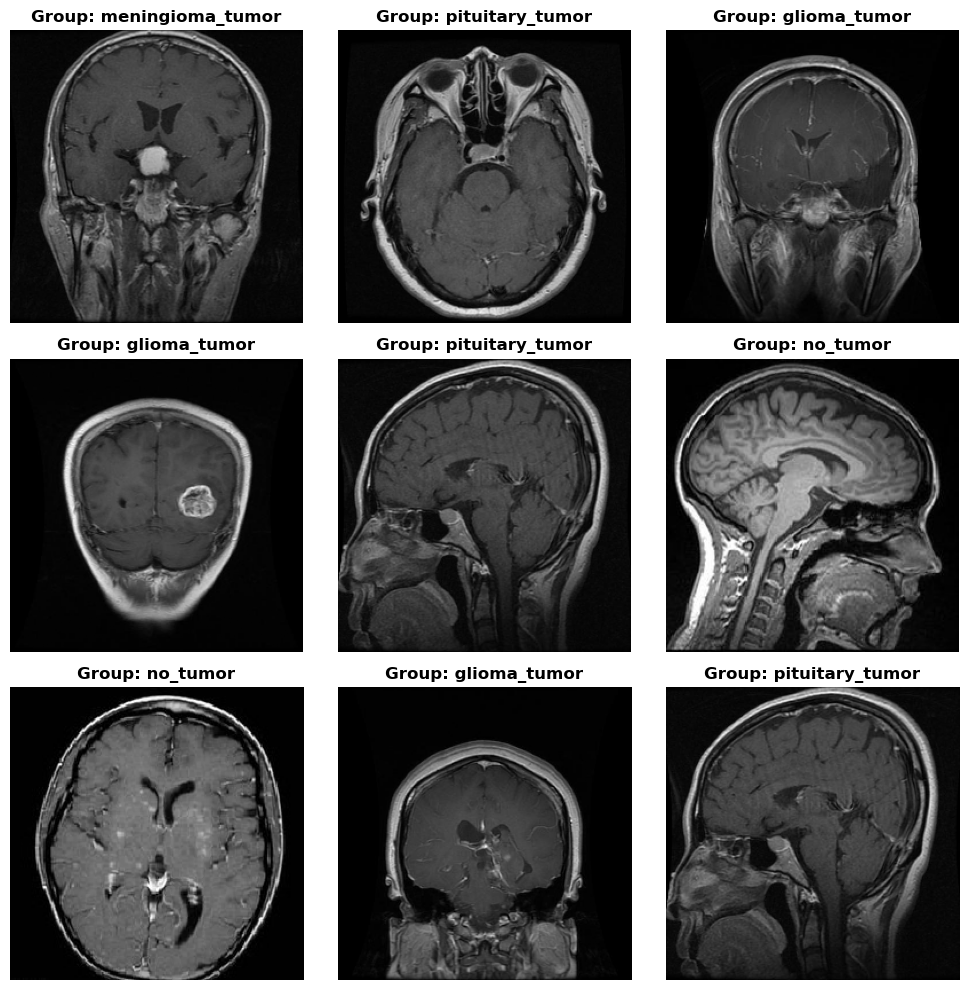

In [12]:
# Function to display 9 random images with labels
print(tf.__version__)
import random
def display_random_images(grouped_images_data):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    # Select 9 random images with their group labels
    random_images = []
    for _ in range(9):
        # Randomly choose a group
        group = random.choice(list(grouped_images_data.keys()))
        # Randomly select an image from the chosen group
        image = random.choice(grouped_images_data[group])
        random_images.append((image, group))

    # Plot the images
    for ax, (image, group) in zip(axes, random_images):
        ax.imshow(image)
        ax.set_title(f"Group: {group}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_random_images(grouped_images_data)

#### Evaluation Metrics and Acceptence Criteria
Given the objective of this project is to spot the presence of a tumor in brain MRI images, the most important metric to consider is the model's ability to correctly answer the question "Is there a tumor?". This is a binary classification problem where the model should be able to correctly identify the presence of a tumor as true positive and the absence of a tumor as true negative. But since we are working with identification problem, we need to consider the following metrics: false positives where the model incorrectly detecting a tumor when where wasn't and false negatives where the model failing to detect a tumor when it is present. In this case, since the matter of the problem is medical, it is crucial to minimize false negatives as it could have severe consequences, while false positives can be further investigated with human intervention most likely fixing the mistake.

Therefore, the most important metrics to consider are the recall score since our main goal is to minimize false negatives. But just because we want to minimize false negatives doesn't mean we should ignore false positives. We should also consider precision score to minimize false positives as well. One attribute of our dataset is that there is an imbalance in the number of no_tumor to tumor images, with tumor image being the majority. This imbalance could lead to a model that predicts tumor for every image, which would result in a high recall score but a low precision score.

 We can combine these two metrics into a single metric with the F1 score, which is the harmonic mean of precision and recall. This will help us evaluate the model's overall performance in balancing false positives and false negatives.

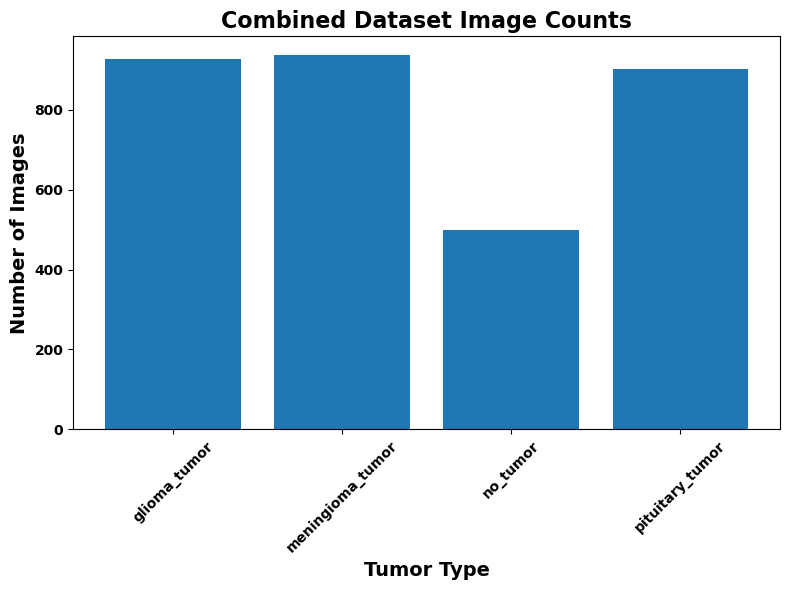

In [13]:
plot_image_counts({group: len(paths) for group, paths in grouped_images.items()}, "Combined Dataset Image Counts")

#### Cross-Validation

Looking at the distribution of images across the different groups, we can see that there is a significant imbalance in the number of images that are no_tumor to tumor. This imbalance can lead to issues when training a machine learning model, especially when using cross-validation. As a result, we will use Stratified 10-Fold Cross-Validation to ensure that each fold has the same proportion of no_tumor to tumor images as the original dataset. The idea is that this will help prevent the model from being biased towards the majority class and provide a more accurate estimate of the model's performance. In the real world scenario, the probability of seeing a tumor is very low, so we need to make sure that our model is able to detect the tumor when it is present and not just detect tumor for every image. On top of that, tumors, just like any other body parts, are unique to every person. You don't want to overfit the model to the training data and have it fail to generalize to new data. This is why we need to balance the classes in each fold of the cross-validation.

In [14]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

print(tf.__version__)
# Flatten the grouped images and labels for cross-validation
all_images = []
all_labels = []
label_map = {'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}

for group, images in grouped_images_data.items():
    labels = np.full(len(images), label_map[group])  # Assign label for each group
    all_images.append(images)
    all_labels.append(labels)

# Convert all images and labels to numpy arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Normalize images
all_images = all_images / 255.0

# Convert labels to categorical (one-hot encoded)
all_labels = to_categorical(all_labels, num_classes=4)

# Initialize Stratified KFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run Stratified 10-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    # Here, you would train your model on X_train and evaluate it on X_val
    print(f"Fold {fold}")
    print(f"Train set size: {len(X_train)}, Validation set size: {len(X_val)}")

    fold += 1

print(f"Shape of xtrain: {X_train.shape}")
print(f"Shape of xval: {X_val.shape}")
print(f"Shape of ytrain: {y_train.shape}")
print(f"Shape of yval: {y_val.shape}")


2.17.0
Fold 1
Train set size: 2937, Validation set size: 327
Fold 2
Train set size: 2937, Validation set size: 327
Fold 3
Train set size: 2937, Validation set size: 327
Fold 4
Train set size: 2937, Validation set size: 327
Fold 5
Train set size: 2938, Validation set size: 326
Fold 6
Train set size: 2938, Validation set size: 326
Fold 7
Train set size: 2938, Validation set size: 326
Fold 8
Train set size: 2938, Validation set size: 326
Fold 9
Train set size: 2938, Validation set size: 326
Fold 10
Train set size: 2938, Validation set size: 326
Shape of xtrain: (2938, 256, 256, 3)
Shape of xval: (326, 256, 256, 3)
Shape of ytrain: (2938, 4)
Shape of yval: (326, 4)


### Modeling
#### Data Augmentation
Before we start building our model, we need to consider the size of our dataset. We have a total of 3064 images, which is a relatively small dataset for training a deep learning model. To help prevent overfitting and improve the model's generalization, we can use data augmentation techniques.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

# Initialize the Sequential model
model = Sequential()

# Add data augmentation layers
model.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model.add(RandomFlip("vertical"))  # Vertical flip
model.add(RandomRotation(0.25))  # Random rotation
model.add(RandomZoom(0.1))  # Random zoom


2.18.0


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Since our data are all MRI brain scans, there are only a few ways we can augment the data to mimic real life MRI scans.
##### Horizontal Flip
    RandomFlip("horizontal", input_shape=(256, 256, 3)
We can flip the images horizontally to simulate length wise mirroring of the head.

##### Vertical Flip
    RandomFlip("vertical")
We can flip the images vertical to simulate width wise mirroring of the head.

##### Rotation
    RandomRotation(0.25)
We can also rotate the images to simulate different angles of the head. The 0.25 means rotation up to plus-or-minus 25% of a circal or 90 degrees. (+/- 90 degrees)

##### Zoom
    RandomZoom(0.1)
We can zoom in and out to simulate different zoom levels of the MRI scan. The 0.1 means zoom up to 10% of the image size. (+/- 10%)

These are the most common data augmentation techniques used for image data. But do keep in mind that because we are working with MRI scans, we need to be careful with the augmentation techniques we use. We don't want to distort the images too much as it could affect the quality of the scans, causing it to become unrealistic. We want to make sure that the augmented images still look like MRI scans of the brain.

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Log the devices TensorFlow will use
tf.debugging.set_log_device_placement(True)

# Test if TensorFlow runs on the GPU
print("Is GPU available? ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
Is GPU available?  []


Model 1

In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Add convolutional layers to the model
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2846 - loss: 1.3744 - val_accuracy: 0.2883 - val_loss: 1.3587
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 608ms/step - accuracy: 0.2941 - loss: 1.3592 - val_accuracy: 0.2883 - val_loss: 1.3590
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 615ms/step - accuracy: 0.2798 - loss: 1.3636 - val_accuracy: 0.2883 - val_loss: 1.3592
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 605ms/step - accuracy: 0.2837 - loss: 1.3612 - val_accuracy: 0.2822 - val_loss: 1.3587
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 597ms/step - accuracy: 0.2704 - loss: 1.3676 - val_accuracy: 0.2822 - val_loss: 1.3607
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 641ms/step - accuracy: 0.2639 - loss: 1.3584 - val_accuracy: 0.2883 - val_loss: 1.3590
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 56s 606ms/step - accuracy: 0.3039 - loss: 1.3603 - val_accuracy: 0.2822 - val_loss: 1.3593
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 585ms/step - accuracy: 0.2614 - loss: 1.3600 - val_accura

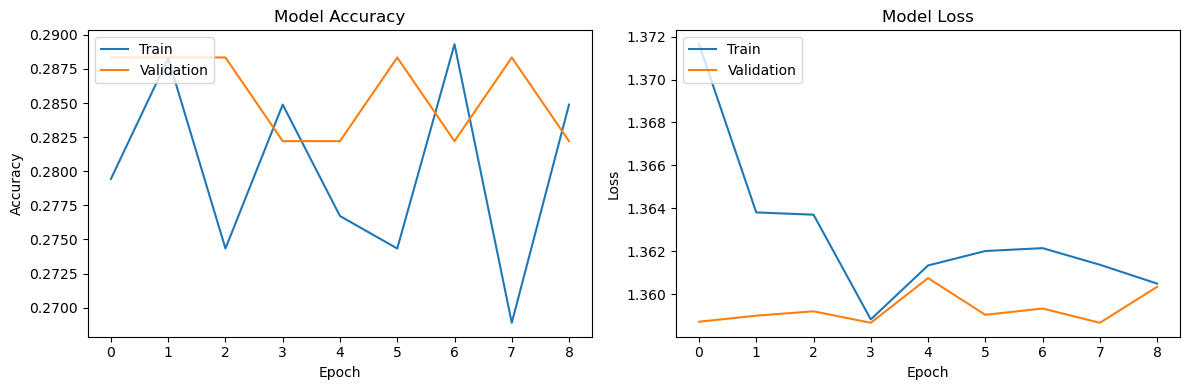

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model 2 (same architecture, different parameter)

In [11]:
model1 = Sequential()

model1.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model1.add(RandomFlip("vertical"))  # Vertical flip
model1.add(RandomRotation(0.25))  # Random rotation
model1.add(RandomZoom(0.1))  # Random zoom

model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='softmax'))

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on validation set
y_val_pred = model1.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")

c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.2800 - loss: 1.3695 - val_accuracy: 0.2761 - val_loss: 1.3601
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.2702 - loss: 1.3696 - val_accuracy: 0.2883 - val_loss: 1.3593
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.2736 - loss: 1.3691 - val_accuracy: 0.2761 - val_loss: 1.3593
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.2800 - loss: 1.3636 - val_accuracy: 0.2883 - val_loss: 1.3682
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.2787 - loss: 1.3662 - val_accuracy: 0.2883 - val_loss: 1.3598
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.2812 - loss: 1.3580 - val_accuracy: 0.2883 - val_loss: 1.3586
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.2753 - loss: 1.3715 - val_accuracy: 0.2883 - val_loss: 1.3585
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.2933 - loss: 1.3600 - val_accuracy: 0.2883 - v

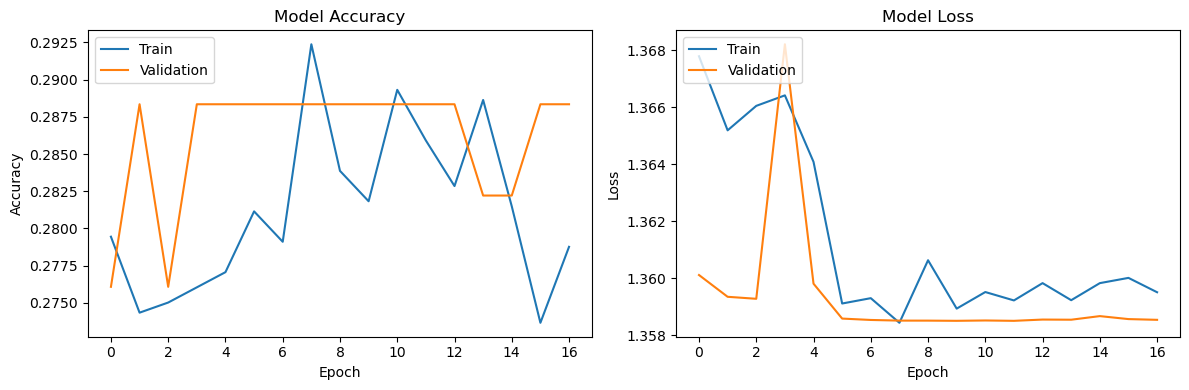

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model 3

In [13]:
from tensorflow.keras.layers import BatchNormalization

model2 = Sequential()

model2.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model2.add(RandomFlip("vertical"))  # Vertical flip
model2.add(RandomRotation(0.25))  # Random rotation
model2.add(RandomZoom(0.1))  # Random zoom

#Different Architecture with Batch Normalization

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on validation set
y_val_pred = model2.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.3845 - loss: 7.2744 - val_accuracy: 0.2761 - val_loss: 3.6557
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3580 - loss: 1.3568 - val_accuracy: 0.2761 - val_loss: 2.4397
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3869 - loss: 1.3468 - val_accuracy: 0.2761 - val_loss: 3.7503
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3983 - loss: 1.3080 - val_accuracy: 0.2761 - val_loss: 1.7519
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.4578 - loss: 1.2224 - val_accuracy: 0.2822 - val_loss: 4.9750
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.4742 - loss: 1.1868 - val_accuracy: 0.2853 - val_loss: 1.3800
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4885 - loss: 1.1472 - val_accuracy: 0.1534 - val_loss: 66.2075
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5174 - loss: 1.1134 - val_accuracy: 0.1534 - 

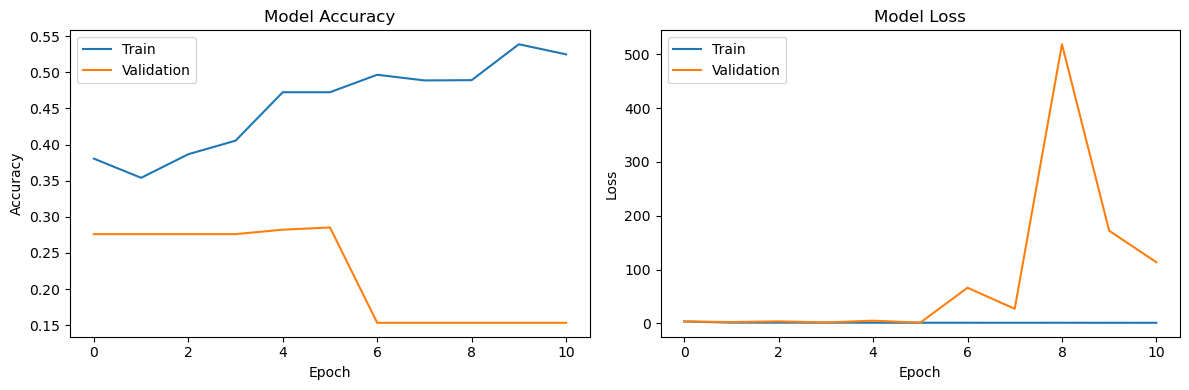

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model 4

In [15]:
model3 = Sequential()

model3.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model3.add(RandomFlip("vertical"))  # Vertical flip
model3.add(RandomRotation(0.25))  # Random rotation
model3.add(RandomZoom(0.1))  # Random zoom

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on validation set
y_val_pred = model3.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.3395 - loss: 28.8349 - val_accuracy: 0.1534 - val_loss: 4.1007
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.2836 - loss: 1.4298 - val_accuracy: 0.1534 - val_loss: 17.2613
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.3006 - loss: 1.4418 - val_accuracy: 0.2761 - val_loss: 18.4050
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.3281 - loss: 1.8329 - val_accuracy: 0.2822 - val_loss: 1.6584
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.3368 - loss: 1.5002 - val_accuracy: 0.1534 - val_loss: 19.8663
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.2873 - loss: 1.4013 - val_accuracy: 0.1534 - val_loss: 59.5805
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.3455 - loss: 1.3416 - val_accuracy: 0.1534 - val_loss: 88.1026
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.3414 - loss: 1.3188 - val_accuracy: 0.15

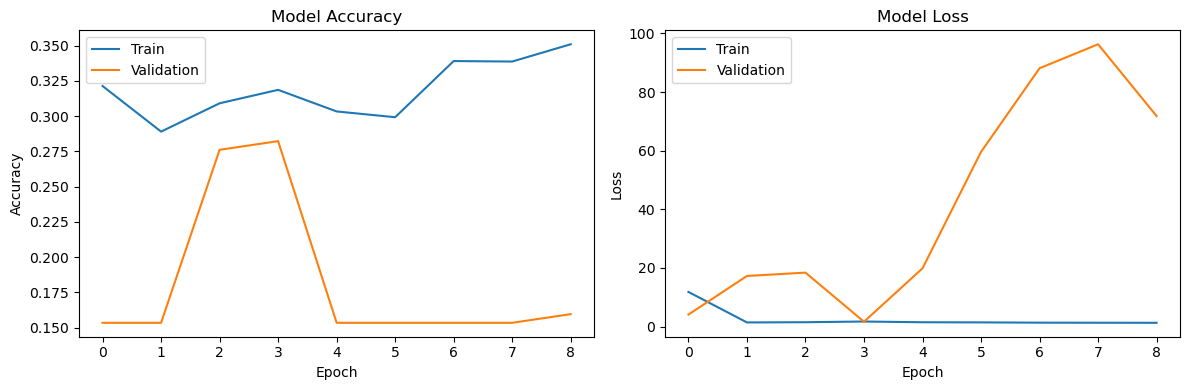

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Combined Plots

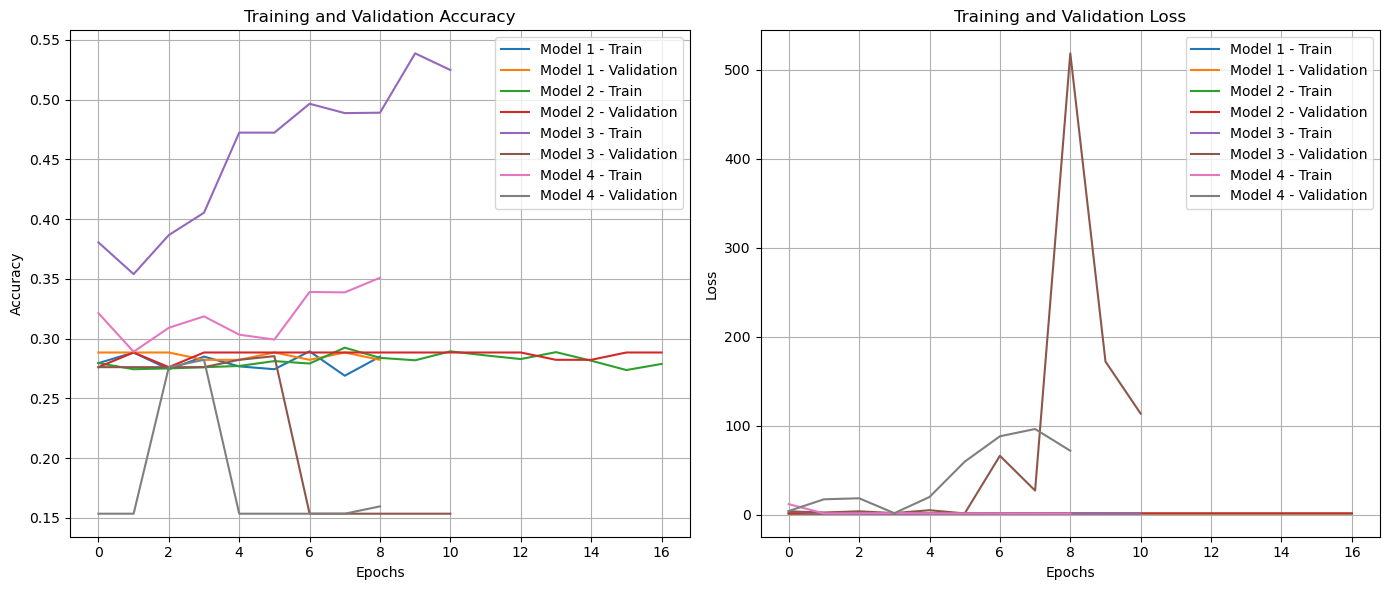

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 - Train')
plt.plot(history.history['val_accuracy'], label='Model 1 - Validation')
plt.plot(history1.history['accuracy'], label='Model 2 - Train')
plt.plot(history1.history['val_accuracy'], label='Model 2 - Validation')
plt.plot(history2.history['accuracy'], label='Model 3 - Train')
plt.plot(history2.history['val_accuracy'], label='Model 3 - Validation')
plt.plot(history3.history['accuracy'], label='Model 4 - Train')
plt.plot(history3.history['val_accuracy'], label='Model 4 - Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model 1 - Train')
plt.plot(history.history['val_loss'], label='Model 1 - Validation')
plt.plot(history1.history['loss'], label='Model 2 - Train')
plt.plot(history1.history['val_loss'], label='Model 2 - Validation')
plt.plot(history2.history['loss'], label='Model 3 - Train')
plt.plot(history2.history['val_loss'], label='Model 3 - Validation')
plt.plot(history3.history['loss'], label='Model 4 - Train')
plt.plot(history3.history['val_loss'], label='Model 4 - Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd


data = {
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    'Final Train Accuracy': [
        history.history['accuracy'][-1],
        history1.history['accuracy'][-1],
        history2.history['accuracy'][-1],
        history3.history['accuracy'][-1]
    ],
    'Final Val Accuracy': [
        history.history['val_accuracy'][-1],
        history1.history['val_accuracy'][-1],
        history2.history['val_accuracy'][-1],
        history3.history['val_accuracy'][-1]
    ],
    'Final Train Loss': [
        history.history['loss'][-1],
        history1.history['loss'][-1],
        history2.history['loss'][-1],
        history3.history['loss'][-1]
    ],
    'Final Val Loss': [
        history.history['val_loss'][-1],
        history1.history['val_loss'][-1],
        history2.history['val_loss'][-1],
        history3.history['val_loss'][-1]
    ]
}

metrics_df = pd.DataFrame(data)
print(metrics_df)


     Model  Final Train Accuracy  Final Val Accuracy  Final Train Loss  \
0  Model 1              0.284888            0.282209          1.360490   
1  Model 2              0.278761            0.288344          1.359504   
2  Model 3              0.524847            0.153374          1.084263   
3  Model 4              0.350919            0.159509          1.291046   

   Final Val Loss  
0        1.360337  
1        1.358536  
2      113.548866  
3       71.808716  


Model 1 and 2 seem to show poor training and validation metrics. The loss for both are consistent but high which suggests they are stuck at a local minmum. Model 3 on the other hand has a very high training accuracy but its Validation accuracy is very low in comparison this suggest that Model 3 is overfitting. Its loss is very high which suggests unstable learning or a divergence. Model 4 has better accuracy than both 1 and 2 but lower than model 3 however its validation is low which suggests it is overfitting as well. It also has a high loss but its lower than 3 which indicates some training progress,

# MLP

In [19]:
from tensorflow.keras.utils import to_categorical

def create_mlp(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' )
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")


# Reshape the image data to 1D arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Normalize flattened data
X_train_flat = X_train_flat / 255.0
X_val_flat = X_val_flat / 255.0

print(f"Shape of X_train_flat: {X_train_flat.shape}")
print(f"Shape of X_val_flat: {X_val_flat.shape}")

input_dim = X_train_flat.shape[1]
num_classes = y_train.shape[1]
mlp_model = create_mlp(input_dim=input_dim, num_classes=num_classes)

history4 = mlp_model.fit(
    X_train_flat, y_train,  # Use one-hot encoded labels
    validation_data=(X_val_flat, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


y_val_pred = mlp_model.predict(X_val_flat)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")


Shape of y_train: (2938, 4)
Shape of y_val: (326, 4)
Shape of X_train_flat: (2938, 196608)
Shape of X_val_flat: (326, 196608)


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.2773 - loss: 1.3769 - val_accuracy: 0.2883 - val_loss: 1.3585
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.2845 - loss: 1.3587 - val_accuracy: 0.2883 - val_loss: 1.3562
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.2913 - loss: 1.3463 - val_accuracy: 0.3190 - val_loss: 1.3522
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.3233 - loss: 1.3494 - val_accuracy: 0.4847 - val_loss: 1.3390
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.3839 - loss: 1.3419 - val_accuracy: 0.4509 - val_loss: 1.3129
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.4607 - loss: 1.3058 - val_accuracy: 0.4724 - val_loss: 1.2466
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.4793 - loss: 1.2313 - val_accuracy: 0.5092 - val_loss: 1.1634
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.5387 - loss: 1.1245 - val_accu

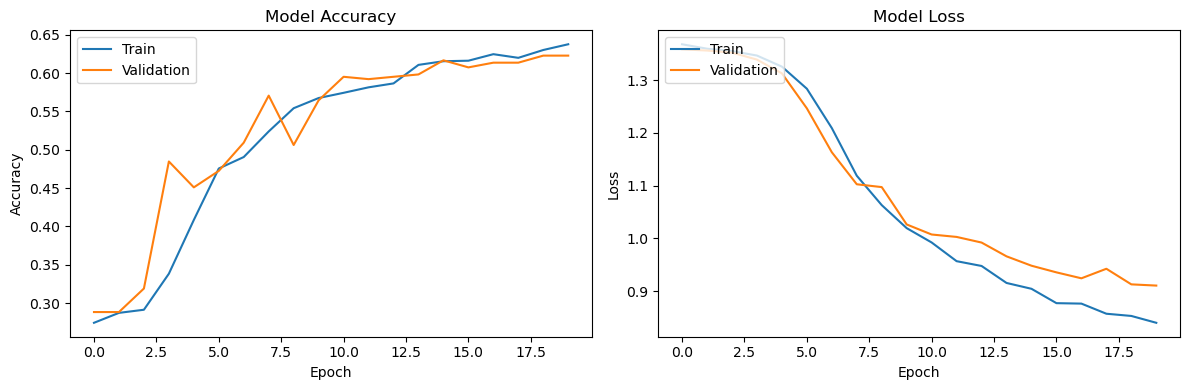

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# ROC and AUC comparison


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step


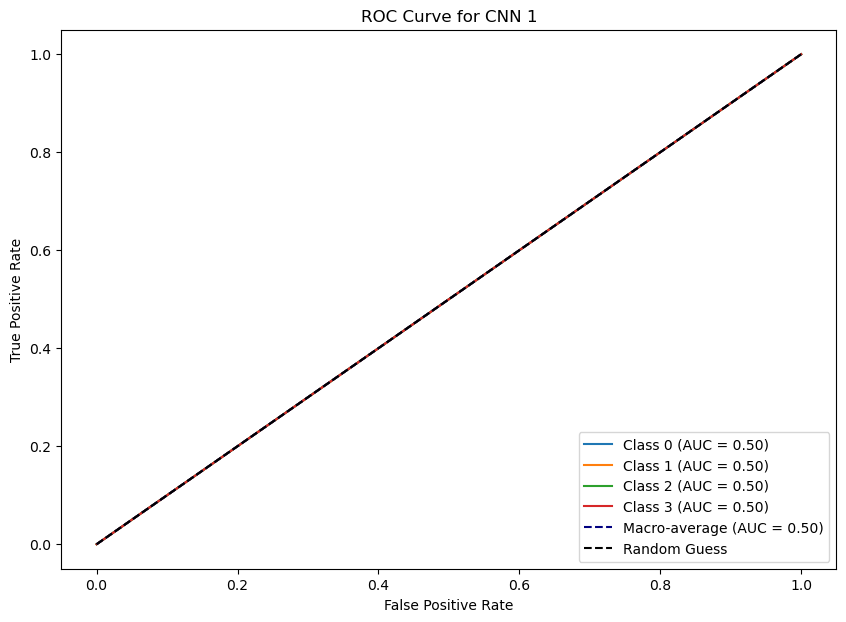

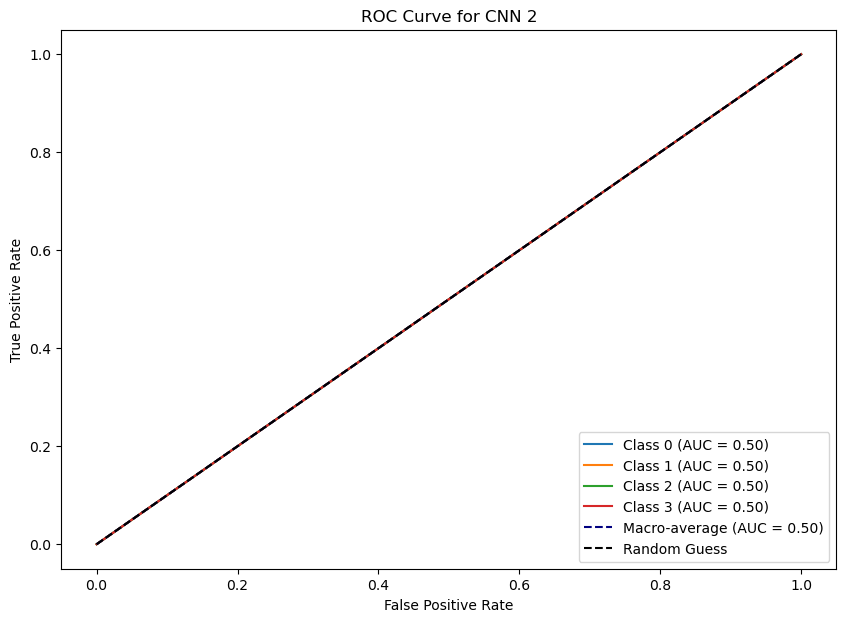

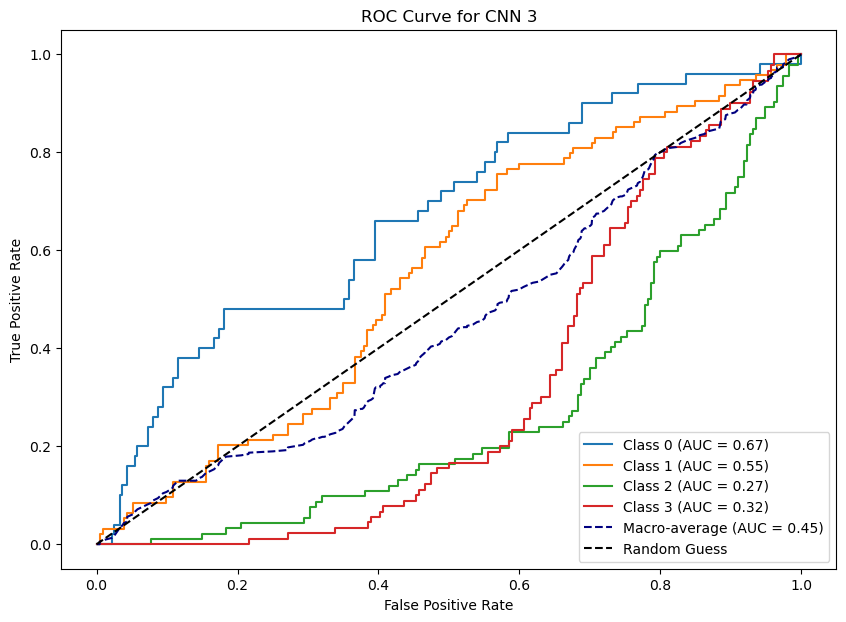

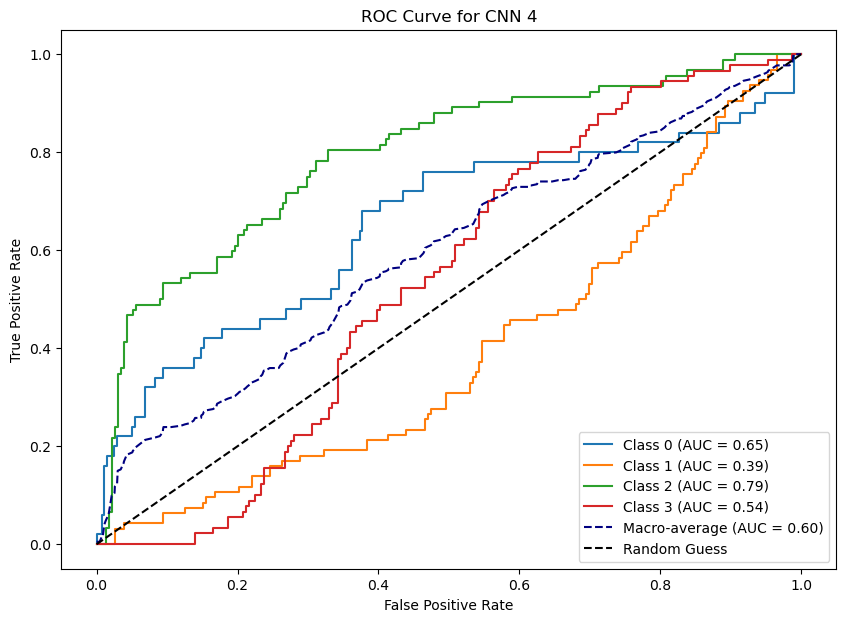

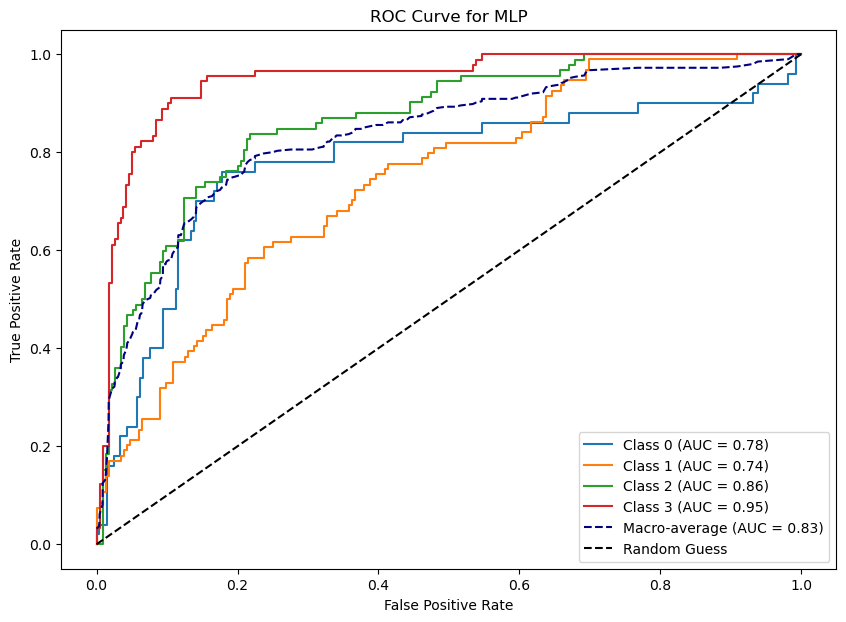

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(y_true, y_pred_probs, model_name):
    n_classes = y_true.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 7))

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, linestyle='--', label=f'Macro-average (AUC = {macro_auc:.2f})', color='navy')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

mlp_prob = mlp_model.predict(X_val_flat)
cnn_prob1 = model.predict(X_val)
cnn_prob2 = model1.predict(X_val)
cnn_prob3 = model2.predict(X_val)
cnn_prob4 = model3.predict(X_val)

cnn_auc1 = plot_roc(y_val, cnn_prob1, model_name="CNN 1")
cnn_auc2 = plot_roc(y_val, cnn_prob2, model_name="CNN 2")
cnn_auc3 = plot_roc(y_val, cnn_prob3, model_name="CNN 3")
cnn_auc4 = plot_roc(y_val, cnn_prob4, model_name="CNN 4")
mlp_auc = plot_roc(y_val, mlp_prob, model_name="MLP")


Both CNN 1 and 2 performed poorly indicated by an AUC ~.5 and are not better than randomly guessing. Model 3 shows some imporvement with AUC values ranging from .27 to .67. The macro average of .45 suggest limited effectivness but its better than 1 and 2. CNN 4 perfrom better than 3 with AUC range of .39 to .79 and a macro average of .60. The MLP performed significantly better than the CNN models with AUC range of .74 to .94 and a macro averag of .83. The CNN performance degradation is likely due to a poor or insufficient data.

## Exceptional Work

Using transfer learning with pre-trained weights. The best performing CNN model from above was Model 4, so that is what we will be working with here.

In [17]:
# Some code taken from https://www.geeksforgeeks.org/ml-transfer-learning-with-convolutional-neural-networks/
from keras.applications.resnet50 import ResNet50
from keras.layers import RandomFlip, RandomRotation, RandomZoom, Dense, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import f1_score

# by default, the loaded model will include the original CNN
#classifier designed for the ImageNet dataset
# since we want to reuse this model for a different problem,
# we need to omit the original fully connected layers, and
# replace them with our own setting include_top = False will
# load the model without the fully connected layer

# load resnet model, with pretrained imagenet weights.
res = ResNet50(weights ='imagenet', include_top = False,
               input_shape =(256, 256, 3))

model3 = Sequential()

model3.add(RandomFlip("horizontal", input_shape=(256, 256, 3)))  # Horizontal flip
model3.add(RandomFlip("vertical"))  # Vertical flip
model3.add(RandomRotation(0.25))  # Random rotation
model3.add(RandomZoom(0.1))  # Random zoom

# passes in the pre-trained weights from the ResNet50 object
model3.add(res)

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on validation set
y_val_pred = model3.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print(f"F1 Score: {f1}")

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 639s 7s/step - accuracy: 0.5206 - loss: 1.4603 - val_accuracy: 0.2761 - val_loss: 68.1652
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2902s 32s/step - accuracy: 0.6282 - loss: 1.0520 - val_accuracy: 0.1534 - val_loss: 534.3238
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 514s 6s/step - accuracy: 0.6715 - loss: 0.9192 - val_accuracy: 0.2822 - val_loss: 3.7805
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.7543 - loss: 0.6454 - val_accuracy: 0.2822 - val_loss: 2.4077
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 580s 6s/step - accuracy: 0.7838 - loss: 0.5715 - val_accuracy: 0.1534 - val_loss: 3.2924
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.8404 - loss: 0.4625 - val_accuracy: 0.1534 - val_loss: 2.7837
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 633s 7s/step - accuracy: 0.8736 - loss: 0.3853 - val_accuracy: 0.1534 - val_loss: 1.9957
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 589s 6s/step - accuracy: 0.8588 - loss: 0.4036 - val_accuracy: 0.153

The accuracy for the model with the pre-trained weights is significantly higher than the accuracy for model 4. Model 4's max accuracy was 34.64%, whereas the model with the pre-trained weights had a max accuracy of 88.48%. However, the model with the pre-trained weights has a much lower F1 score of 0.04 compared to Model 4's F1 score of 0.12.